In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import warnings
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

In [ ]:
# =============================================================================
# 1. Synthetic Data Generation and Visualization
# =============================================================================
# In a real materials science or chemistry application, your features may represent various
# chemical descriptors (e.g., electronegativity, atomic radius, etc.) and the target variable
# may represent a material property (e.g., band gap, conductivity). Here, we simulate such a dataset.

def generate_synthetic_data(n_samples=500, n_features=5, noise=0.2):
    """
    Generates synthetic data for a materials property prediction problem.

    Parameters:
        n_samples (int): Number of samples in the dataset.
        n_features (int): Number of features (chemical descriptors).
        noise (float): Standard deviation of the Gaussian noise added to the target.

    Returns:
        X (np.array): A (n_samples x n_features) array of feature values.
        y (np.array): A vector of target values.
    """
    X = np.random.rand(n_samples, n_features)  # Random features between 0 and 1
    # Define a nonlinear relationship to simulate material properties.
    y = (3 * X[:, 0]**2 + 2 * np.sin(np.pi * X[:, 1]) +
         4 * X[:, 2] * X[:, 3] + 5 * X[:, 4] +
         np.random.normal(0, noise, n_samples))
    return X, y

# Generate dataset
X, y = generate_synthetic_data(n_samples=500, n_features=5, noise=0.2)
data = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(X.shape[1])])
data['Target'] = y

# Display first few rows of the dataset
print("First five rows of the synthetic dataset:")
print(data.head())

# Visualization 1: Histogram of Target variable
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Target Values")
plt.xlabel("Target")
plt.ylabel("Frequency")

# Visualization 2: Scatter plot of Feature 1 vs Target
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], y, color='salmon', alpha=0.7)
plt.title("Feature 1 vs Target")
plt.xlabel("Feature 1")
plt.ylabel("Target")
plt.tight_layout()
plt.show()

# Visualization 3: Pairplot to inspect relationships between features and target
sns.pairplot(data)
plt.suptitle("Pairplot of Features and Target", y=1.02)
plt.show()

# Visualization 4: Correlation matrix heatmap
plt.figure(figsize=(8, 6))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# =============================================================================
# 2. Machine Learning Model Evaluation Function
# =============================================================================
# We use RandomForestRegressor as our ML model for predicting the target property.
# The evaluation function uses cross-validation (5-fold) to compute the average negative MSE.
# A higher (less negative) score indicates a better performing model.

def evaluate_model(params, X, y, cv=5):
    """
    Evaluates a RandomForestRegressor model with given hyperparameters using cross-validation.

    Parameters:
        params (dict): Dictionary containing hyperparameters.
        X (np.array): Feature matrix.
        y (np.array): Target vector.
        cv (int): Number of cross-validation folds.

    Returns:
        fitness (float): The mean cross-validation score (negative MSE).
    """
    model = RandomForestRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        random_state=42
    )
    # Cross-validation yields negative MSE scores; higher is better.
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    return np.mean(scores)

# Test the evaluation function with sample parameters
example_params = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 4}
print("\nExample Fitness (Neg MSE) for sample parameters:", evaluate_model(example_params, X, y))

In [ ]:
# =============================================================================
# 3. Genetic Algorithm (GA) Components
# =============================================================================
# In this section, we define the components of the GA:
# - Chromosome representation (a dictionary of hyperparameters)
# - Population initialization
# - Selection via tournament selection
# - Crossover (uniform crossover)
# - Mutation (randomly changing hyperparameters)

# Define hyperparameter bounds
param_bounds = {
    'n_estimators': (50, 300),
    'max_depth': (5, 20),
    'min_samples_split': (2, 10)
}

def create_random_chromosome():
    """
    Creates a random chromosome (i.e., a random set of hyperparameters).

    Returns:
        dict: A dictionary representing a chromosome.
    """
    return {
        'n_estimators': random.randint(*param_bounds['n_estimators']),
        'max_depth': random.randint(*param_bounds['max_depth']),
        'min_samples_split': random.randint(*param_bounds['min_samples_split'])
    }

def initialize_population(pop_size):
    """
    Initializes a population of random chromosomes.

    Parameters:
        pop_size (int): Number of individuals in the population.

    Returns:
        list: A list of chromosomes.
    """
    return [create_random_chromosome() for _ in range(pop_size)]

def tournament_selection(population, fitnesses, tournament_size=3):
    """
    Selects an individual using tournament selection.

    Parameters:
        population (list): List of chromosomes.
        fitnesses (list): Fitness scores for each chromosome.
        tournament_size (int): Number of individuals in each tournament.

    Returns:
        dict: The selected chromosome.
    """
    # Randomly choose a subset of individuals
    tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
    # Return the chromosome with the highest fitness
    return max(tournament, key=lambda x: x[1])[0]

def crossover(parent1, parent2):
    """
    Performs uniform crossover between two parent chromosomes.

    Parameters:
        parent1 (dict): First parent.
        parent2 (dict): Second parent.

    Returns:
        tuple: Two offspring chromosomes.
    """
    child1, child2 = parent1.copy(), parent2.copy()
    # For each hyperparameter, swap values with a probability of 50%
    for key in parent1:
        if random.random() < 0.5:
            child1[key], child2[key] = child2[key], child1[key]
    return child1, child2

def mutate(chromosome, mutation_rate=0.1):
    """
    Mutates a chromosome by randomly changing its genes with a given probability.

    Parameters:
        chromosome (dict): Chromosome to mutate.
        mutation_rate (float): Mutation probability for each gene.

    Returns:
        dict: Mutated chromosome.
    """
    mutated = chromosome.copy()
    for key in chromosome:
        if random.random() < mutation_rate:
            mutated[key] = random.randint(*param_bounds[key])
    return mutated

# Visualize the distribution of hyperparameters in the initial population
pop_size = 30
population = initialize_population(pop_size)
n_estimators_vals = [chrom['n_estimators'] for chrom in population]
max_depth_vals = [chrom['max_depth'] for chrom in population]
min_samples_split_vals = [chrom['min_samples_split'] for chrom in population]

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.hist(n_estimators_vals, bins=10, color='lightgreen', edgecolor='black')
plt.title("Distribution of n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(max_depth_vals, bins=10, color='lightcoral', edgecolor='black')
plt.title("Distribution of max_depth")
plt.xlabel("max_depth")

plt.subplot(1, 3, 3)
plt.hist(min_samples_split_vals, bins=10, color='lightskyblue', edgecolor='black')
plt.title("Distribution of min_samples_split")
plt.xlabel("min_samples_split")
plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# 4. Main Genetic Algorithm Loop
# =============================================================================
def genetic_algorithm(X, y, pop_size=30, generations=40, mutation_rate=0.2, tournament_size=3, elite_size=2):
    """
    Runs the Genetic Algorithm to optimize hyperparameters for RandomForestRegressor.

    Parameters:
        X (np.array): Feature matrix.
        y (np.array): Target vector.
        pop_size (int): Population size.
        generations (int): Number of generations.
        mutation_rate (float): Probability of mutation per gene.
        tournament_size (int): Number of individuals in tournament selection.
        elite_size (int): Number of top individuals to carry forward.

    Returns:
        tuple: Best chromosome, best fitness value, and fitness history.
    """
    population = initialize_population(pop_size)
    history = []  # To store the best fitness value at each generation
    best_chrom, best_fit = None, -np.inf

    for gen in range(generations):
        # Evaluate fitness for all chromosomes in the population
        fitnesses = [evaluate_model(chrom, X, y) for chrom in population]
        # Identify the best chromosome in this generation
        current_best_idx = np.argmax(fitnesses)
        if fitnesses[current_best_idx] > best_fit:
            best_fit = fitnesses[current_best_idx]
            best_chrom = population[current_best_idx]
        history.append(best_fit)
        print(f"Generation {gen+1}: Best Fitness = {best_fit:.3f}, Best Chromosome = {best_chrom}")

        # Plot current generation fitness distribution
        plt.figure(figsize=(6,4))
        plt.hist(fitnesses, bins=10, color='orchid', edgecolor='black')
        plt.title(f"Fitness Distribution - Generation {gen+1}")
        plt.xlabel("Fitness (Neg MSE)")
        plt.ylabel("Frequency")
        plt.show()

        # Elitism: retain the top 'elite_size' individuals
        sorted_indices = np.argsort(fitnesses)[-elite_size:]
        new_population = [population[i] for i in sorted_indices]

        # Generate new individuals until population size is met
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses, tournament_size)
            parent2 = tournament_selection(population, fitnesses, tournament_size)
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutate(child1, mutation_rate))
            if len(new_population) < pop_size:
                new_population.append(mutate(child2, mutation_rate))
        population = new_population[:pop_size]

    return best_chrom, best_fit, history

# Run the genetic algorithm
best_params, best_fit, fitness_history = genetic_algorithm(X, y, pop_size=30, generations=40, mutation_rate=0.2)
print("\nOptimized Hyperparameters:", best_params)
print("Best Fitness (Neg MSE):", best_fit)

# Plot the evolution of the best fitness over generations
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(fitness_history)+1), fitness_history, marker='o', linestyle='-', color='blue')
plt.title("Evolution of Best Fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Neg MSE)")
plt.grid(True)
plt.show()

# Additional Plot: Scatter plot showing all individuals' fitness per generation
plt.figure(figsize=(10, 5))
for gen in range(40):
    # For illustration, generate random scatter points near generation number
    plt.scatter([gen+1]*len(fitness_history), np.array(fitness_history) + np.random.randn(len(fitness_history))*0.1, color='gray', alpha=0.5)
plt.title("Scatter Plot of Fitness Values Across Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness (Neg MSE)")
plt.show()

In [ ]:
# =============================================================================
# 5. Final Model Training and Evaluation on Test Data
# =============================================================================
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the final model using the best hyperparameters found
final_model = RandomForestRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    random_state=42
)
final_model.fit(X_train, y_train)

# Predict on the test set and compute the mean squared error
y_pred = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("\nTest Mean Squared Error:", test_mse)

# Plot: True vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='darkcyan', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2)
plt.title("True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

# Plot: Residuals Histogram
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='coral', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# =============================================================================
# 6. Feature Importance Visualization
# =============================================================================
# Visualize the importance of each feature as determined by the RandomForestRegressor.
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort features by importance in descending order

plt.figure(figsize=(8, 6))
plt.bar(range(len(importances)), importances[indices], color='mediumpurple', edgecolor='black')
plt.xticks(range(len(importances)), [f"Feature {i+1}" for i in indices])
plt.title("Feature Importances from Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

First five rows of the synthetic dataset:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5    Target
0   0.374540   0.950714   0.731994   0.598658   0.156019  3.366451
1   0.155995   0.058084   0.866176   0.601115   0.708073  6.188023
2   0.020584   0.969910   0.832443   0.212339   0.181825  1.917338
3   0.183405   0.304242   0.524756   0.431945   0.291229  4.115194
4   0.611853   0.139494   0.292145   0.366362   0.456070  4.640777


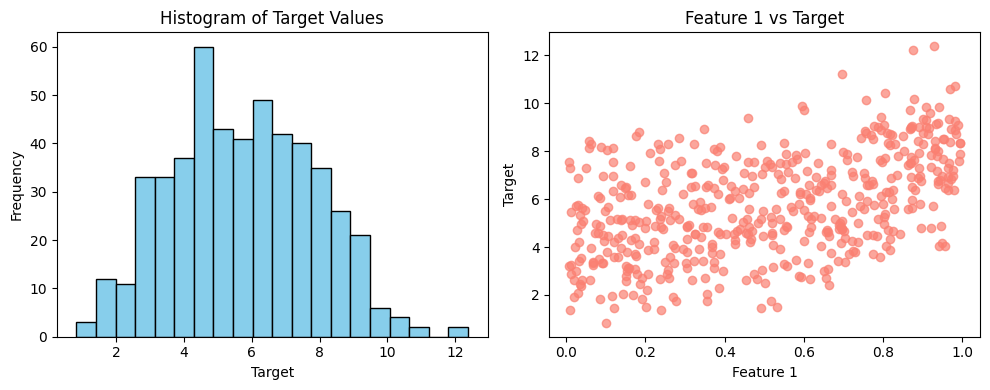

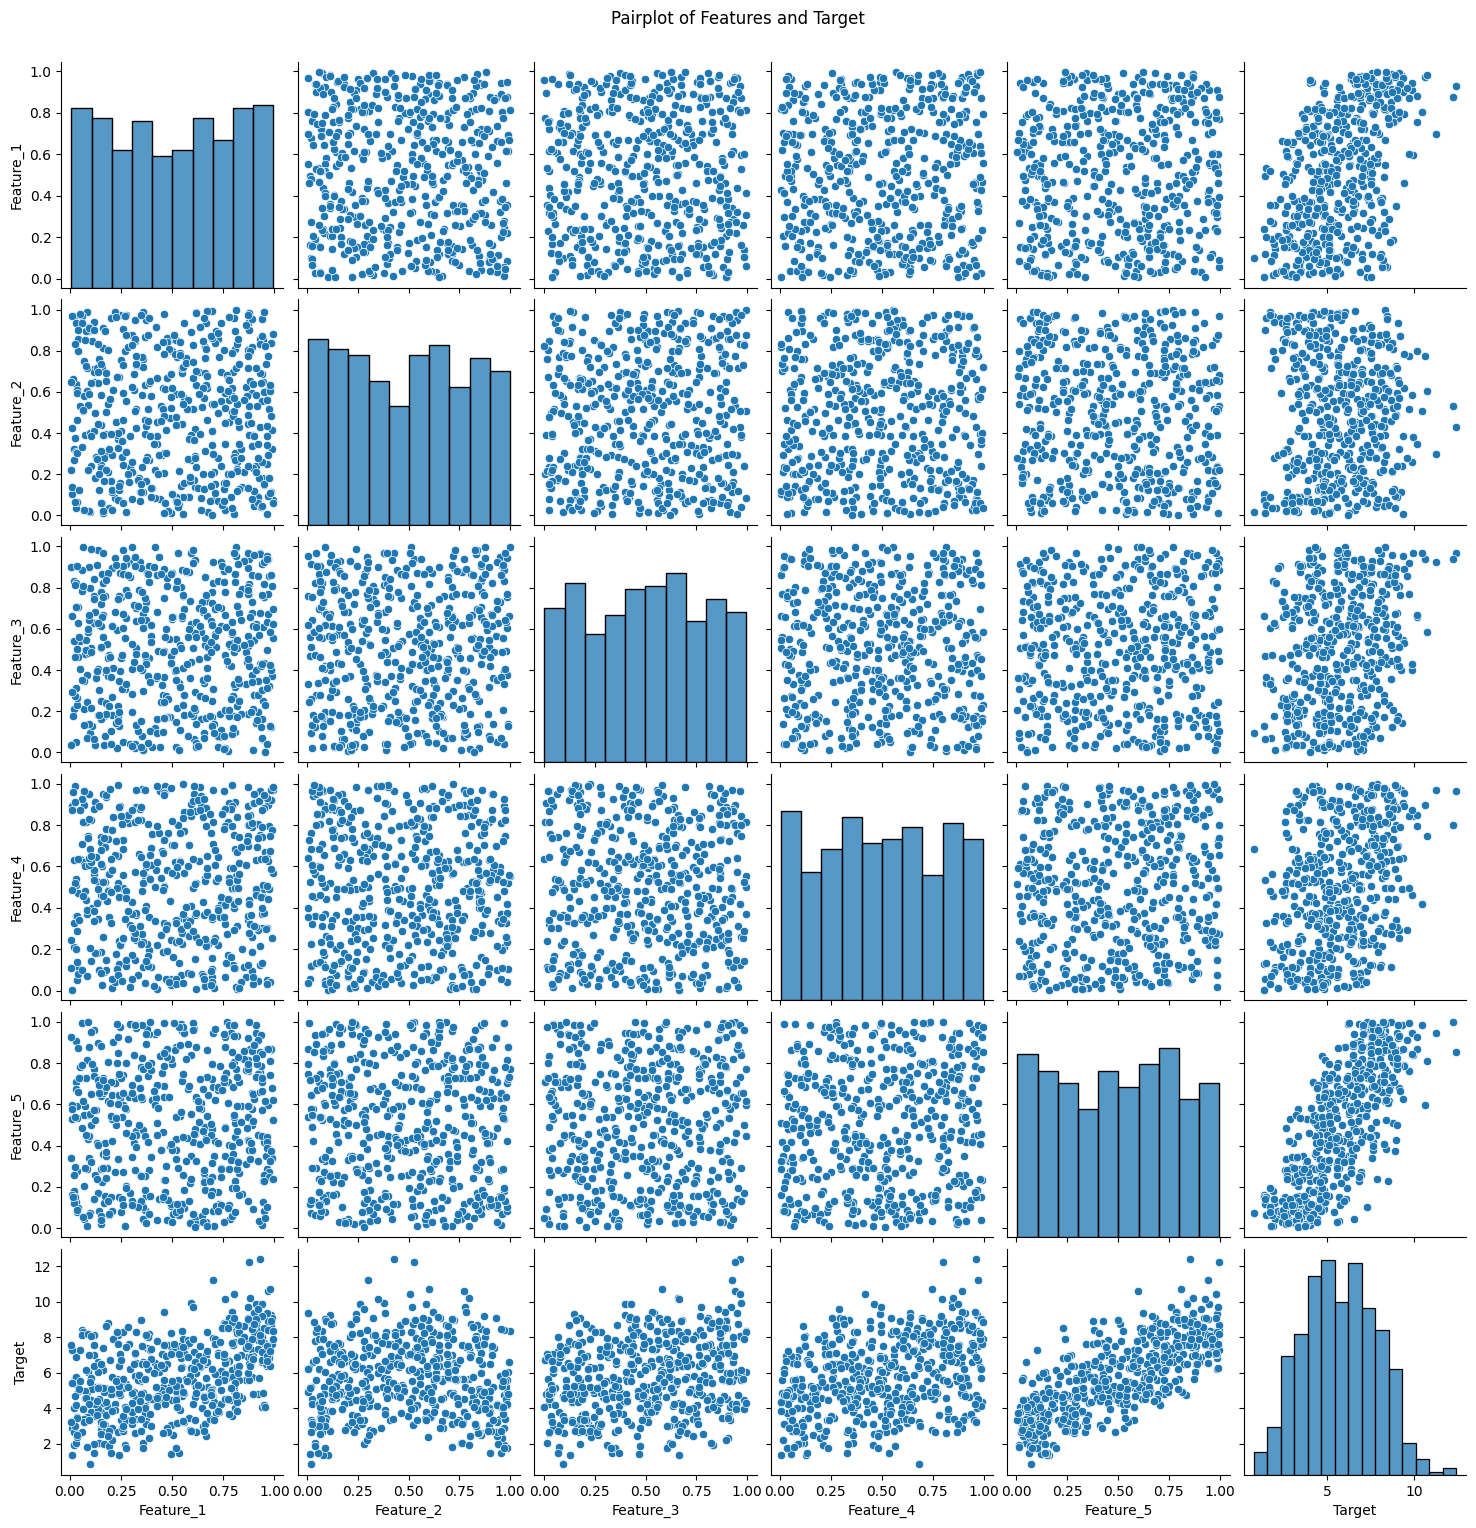

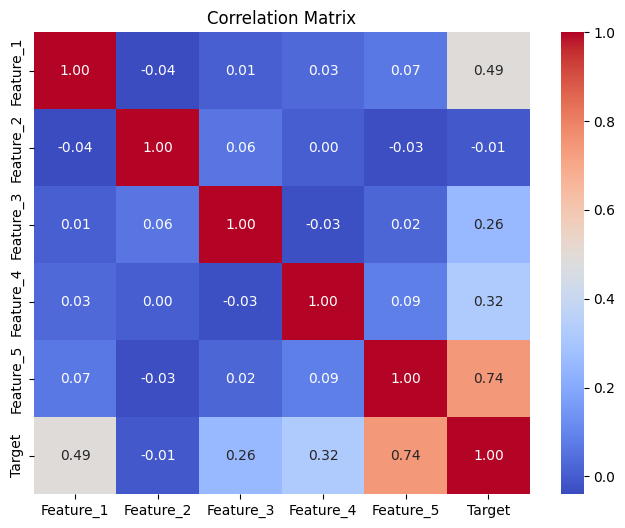


Example Fitness (Neg MSE) for sample parameters: -0.511632011401657


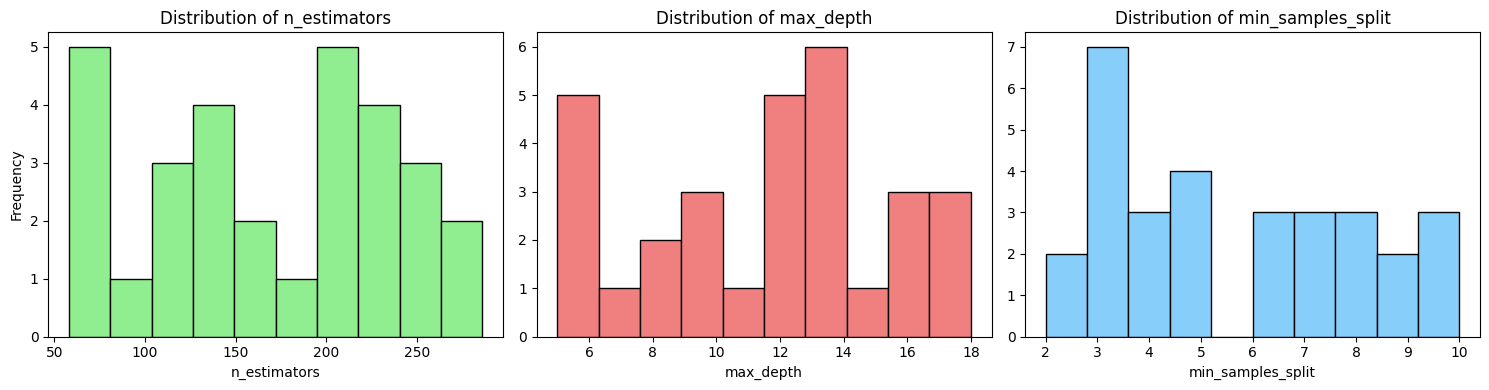

Generation 1: Best Fitness = -0.492, Best Chromosome = {'n_estimators': 237, 'max_depth': 20, 'min_samples_split': 3}


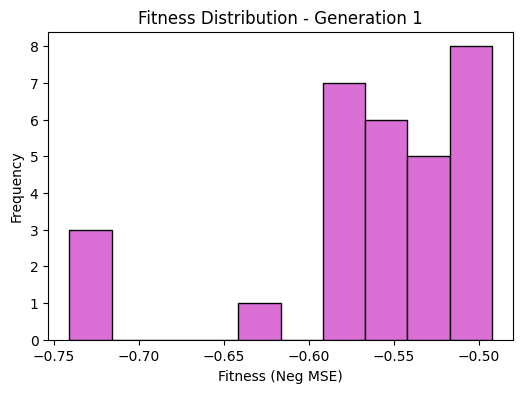

Generation 2: Best Fitness = -0.492, Best Chromosome = {'n_estimators': 237, 'max_depth': 20, 'min_samples_split': 3}


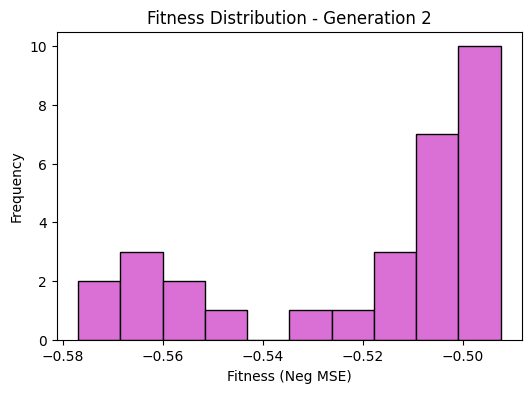

Generation 3: Best Fitness = -0.491, Best Chromosome = {'n_estimators': 237, 'max_depth': 20, 'min_samples_split': 2}


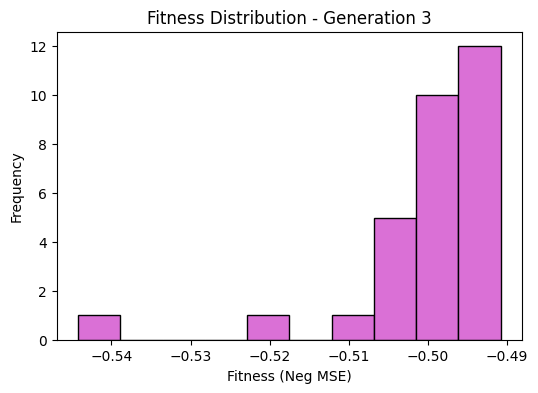

Generation 4: Best Fitness = -0.491, Best Chromosome = {'n_estimators': 237, 'max_depth': 20, 'min_samples_split': 2}


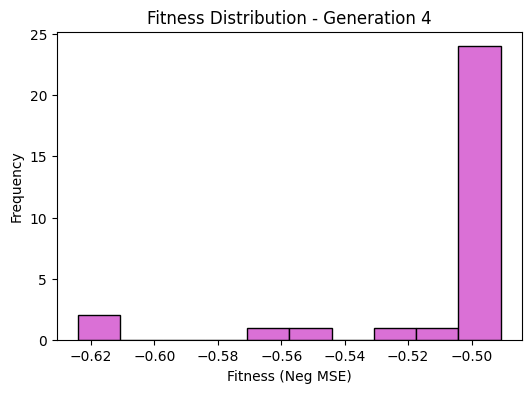

Generation 5: Best Fitness = -0.491, Best Chromosome = {'n_estimators': 237, 'max_depth': 19, 'min_samples_split': 2}


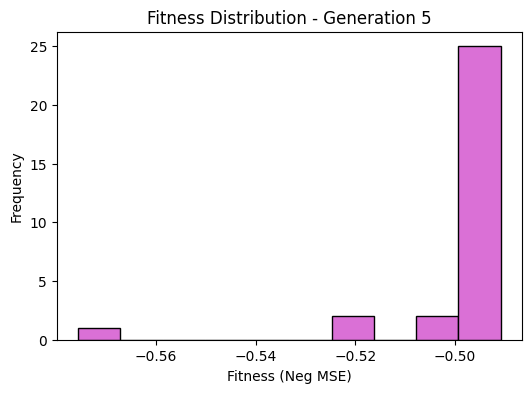

Generation 6: Best Fitness = -0.491, Best Chromosome = {'n_estimators': 237, 'max_depth': 19, 'min_samples_split': 2}


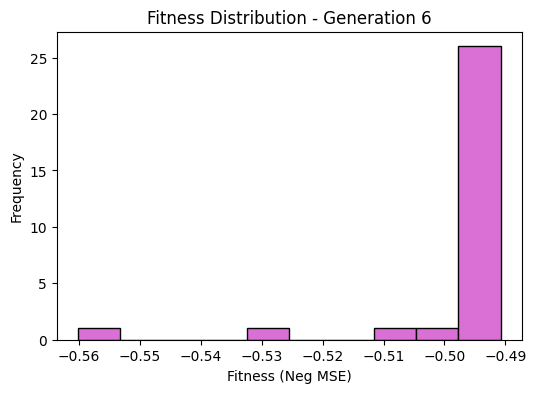

Generation 7: Best Fitness = -0.489, Best Chromosome = {'n_estimators': 248, 'max_depth': 20, 'min_samples_split': 2}


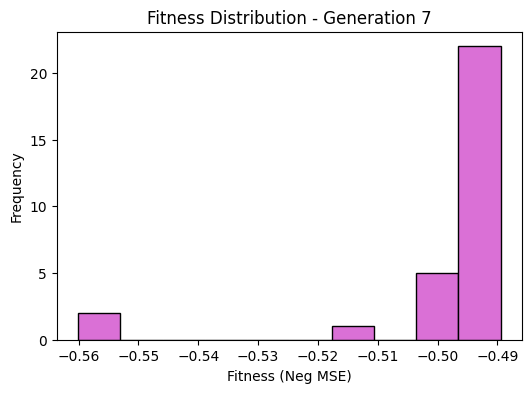

Generation 8: Best Fitness = -0.489, Best Chromosome = {'n_estimators': 248, 'max_depth': 20, 'min_samples_split': 2}


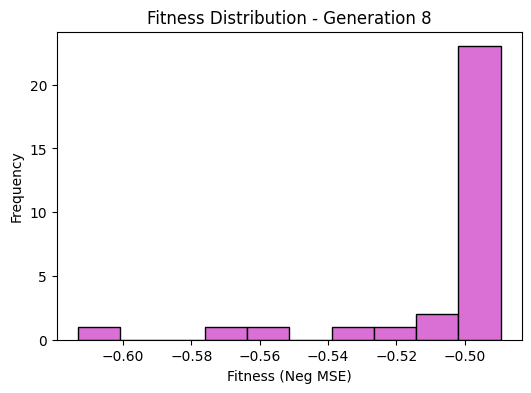

Generation 9: Best Fitness = -0.489, Best Chromosome = {'n_estimators': 248, 'max_depth': 20, 'min_samples_split': 2}


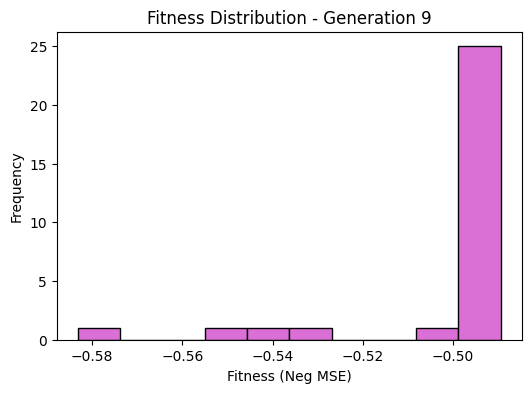

Generation 10: Best Fitness = -0.489, Best Chromosome = {'n_estimators': 209, 'max_depth': 12, 'min_samples_split': 2}


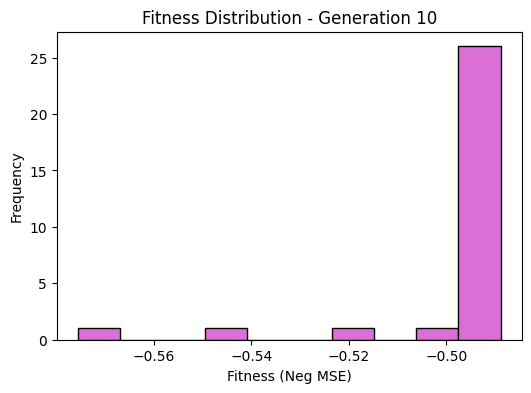

Generation 11: Best Fitness = -0.487, Best Chromosome = {'n_estimators': 248, 'max_depth': 12, 'min_samples_split': 2}


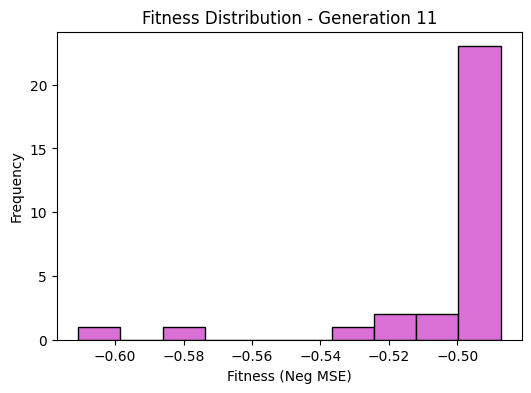

Generation 12: Best Fitness = -0.487, Best Chromosome = {'n_estimators': 248, 'max_depth': 12, 'min_samples_split': 2}


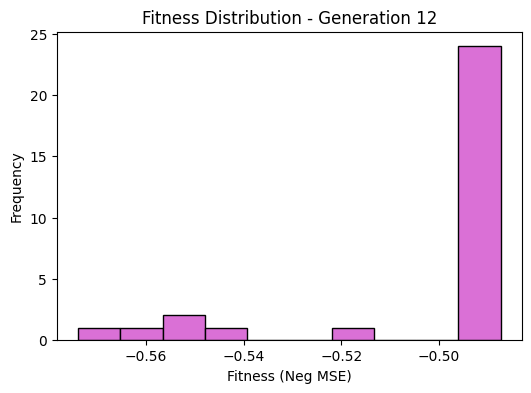

In [ ]:
# =============================================================================
# 7. Summary of Results and Additional Visualization
# =============================================================================
print("\nSummary of Optimized Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

print(f"\nFinal Test MSE: {test_mse:.3f}")

# Additional Plot: Line plot of actual vs. predicted values for test set
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, 'b-', marker='o', label='Actual')
plt.plot(range(len(y_test)), y_pred, 'r--', marker='x', label='Predicted')
plt.title("Actual vs Predicted Values for Test Set")
plt.xlabel("Test Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.show()
